In [1]:
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import calinski_harabasz_score
import time
import re
import threading
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt # plotting
import numpy as np # linear algebra
import os # accessing directory structure
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import ppscore as pps
import seaborn as sns

Create a server...Done
Create a data instance from client...Done
Get data from server...Get data done
Create a model...Done

Get data from server...Get data done
Time taken: 0.04497528076171875



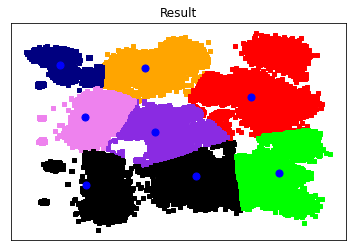

In [3]:
lock = threading.Lock()
class Server:
    def __init__(self, data=np.empty(shape=(0, 2))):
        self.data = data
    # Return data and new index for incoming request
    def responseData(self, currentIndex, batchSize):
        dataLen = len(self.data)
        if currentIndex < dataLen:
            endIndex = currentIndex + batchSize
            endIndex = endIndex if endIndex <= dataLen else dataLen
            return self.data[currentIndex:endIndex], endIndex
        else:
            return np.empty(shape=(0, 2)), dataLen

class CurrentData:
    currentData = np.empty(shape=(0, 2))
    hasNewData = True
    def __init__(self, currentIndex, batchSize):
        self.currentIndex = currentIndex
        self.trainedIndex = currentIndex
        self.batchSize = batchSize
    def getDataFromServer(self, server):
        with lock:
            print("Get data from server...", end="")
            responseCurrentData, responseCurrentIndex = server.responseData(self.currentIndex, self.batchSize)
            if(responseCurrentIndex > self.currentIndex):
#                 with lock:
                    self.hasNewData = True
                    self.currentData = np.append(self.currentData, responseCurrentData, axis=0)
                    self.currentIndex = responseCurrentIndex
            else:
#                 with lock:
                    self.hasNewData = False
            print("Get data done")
    def getDataLen(self):
        with lock:
            return self.currentData.size
    def getData(self):
        with lock:
            return self.currentData
    def clearCurrentData(self):
        with lock:
            self.currentData = np.empty(shape=(0, 2))
    def updateTrainedIndex(self, newIndex):
        with lock:
            self.trainedIndex = newIndex
    def getDim(self):
        with lock:
            return self.currentData.ndim
class Model:
    model = None
    currentIndex = 0
    def __init__(self, currentData, numClusters = None, batchSize = None, clusters = None):
        self.currentData = currentData
        self.dim = self.currentData.getDim()
        self.numClusters = numClusters
        self.batchSize = batchSize if batchSize else 1000
        self.clusters = clusters
        self.createModelAndCluster()
    def createModelAndCluster(self):
        # get first batch data
        firstData = self.currentData.getData()
        firstDataLen = self.currentData.getDataLen()
        # choose cluster number
        if self.numClusters:
            self.model = MiniBatchKMeans(n_clusters=self.numClusters, random_state=0, 
                            batch_size=self.batchSize).fit(firstData)
        else:
            calinski_harabasz_last_score = 0
            lastModel = None
            numClusters = 2
            for k in range(2, 20):
                kModel = MiniBatchKMeans(n_clusters=k, random_state=0, 
                            batch_size=self.batchSize).fit(firstData)
                kScore = calinski_harabasz_score(firstData, kModel.labels_)
                if calinski_harabasz_last_score >= kScore:
                    break
                else:
                    calinski_harabasz_last_score = kScore
                    lastModel = kModel
                    numClusters = k
            if lastModel:
                self.model = lastModel
                self.numClusters = numClusters
        # import clusters data if exist, create if no
        if self.clusters:
            self.model.cluster_centers_ = self.clusters
        else:
            self.clusters = self.model.cluster_centers_
    def startTraining(self):
        start = time.time()

        # get current index
        with lock:
            tempIndex = self.currentData.currentIndex
        self.model.partial_fit(self.currentData.getData())
        self.clusters = self.model.cluster_centers_
        self.currentData.updateTrainedIndex(tempIndex) # update trained index to data storage
        print ("Time taken:", time.time() - start, end="\n\n")

# Utils
def getFileData(path):
    data = []
    with open(path, "r") as f:
        for _, l in enumerate(f):
            # filter: keep only didgits in the data
            data += [[float(x) for x in re.compile("[0-9]+").findall(l)]]
            pass
    return np.array(data)

# Threads
def getDataFromServer(server, currentData):
    while 1:
        # Always check for new data
        currentData.getDataFromServer(server)
        # Turn off thread if no new data is coming
        if not currentData.hasNewData:
            break
def training(model, currentData):
    while 1:
        # Always check for new data, only training if new data has goten
        if currentData.trainedIndex < currentData.currentIndex:
            model.startTraining()
        # Turn off thread if no new data is coming
        if currentData.trainedIndex == currentData.currentIndex:
            break
            
# Run
print("Create a server...", end="")
server = Server(getFileData("./../data/birch.txt"))
print("Done")

print("Create a data instance from client...", end="")
currentData = CurrentData(currentIndex=0, batchSize=100000)
print("Done")
currentData.getDataFromServer(server)

print("Create a model...", end="")
model = Model(currentData, numClusters=8)
print("Done\n")

# Start threads
d = threading.Thread(name='Get data thread', target=getDataFromServer, args=[server, currentData])
t = threading.Thread(name='Training thread', target=training, args=[model, currentData])
# t.setDaemon(True) # If d thread off t thread will off automatically

d.start()
t.start()

d.join()
t.join()

# Visualize
plt.figure(1)
cmap = ['black', 'orange', 'red', 'lime', 'navy', 'blueviolet', 'violet', 'black']
for i in range(model.numClusters):
    cluster_data = model.model.labels_ == i
    X = currentData.getData()
    plt.scatter(X[cluster_data, 0], X[cluster_data, 1],
                c=cmap[i], marker='s', s=10)
plt.scatter(model.clusters[:, 0], model.clusters[:, 1], c='b', s=50)
plt.title("Result")
plt.xticks([])
plt.yticks([])
plt.show()